In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

from transform_image_to_target import *
from adv_utils import *

### Fit of a simple Convolutional Neural Network with 3 layers: Conv2d, MaxPool2d and a fully connected layer (output is 1X10 with a value for each class, those values are not probabilities yet, since they don't go through a softmax function)

In [2]:
batch_size = 64
epochs = 5
learning_rate = 0.1

train_loader, test_loader = load_kmnist(batch_size)

model = KernelFitter()
train_model(model, train_loader, epochs, learning_rate)

Epoch 0, Batch 0, Loss: 0.0231
Epoch 0, Batch 250, Loss: 1.2885
Epoch 0, Batch 500, Loss: 0.4972
Epoch 0, Batch 750, Loss: 0.3927
Epoch 1, Batch 0, Loss: 0.0011
Epoch 1, Batch 250, Loss: 0.3020
Epoch 1, Batch 500, Loss: 0.2752
Epoch 1, Batch 750, Loss: 0.2647
Epoch 2, Batch 0, Loss: 0.0013
Epoch 2, Batch 250, Loss: 0.2248
Epoch 2, Batch 500, Loss: 0.2328
Epoch 2, Batch 750, Loss: 0.2131
Epoch 3, Batch 0, Loss: 0.0009
Epoch 3, Batch 250, Loss: 0.1989
Epoch 3, Batch 500, Loss: 0.2001
Epoch 3, Batch 750, Loss: 0.1758
Epoch 4, Batch 0, Loss: 0.0003
Epoch 4, Batch 250, Loss: 0.1810
Epoch 4, Batch 500, Loss: 0.1691
Epoch 4, Batch 750, Loss: 0.1865


In [3]:
train_loader, test_loader = load_kmnist()

test_iter = iter(test_loader)
inputs, labels = next(test_iter)  # Get a batch of test data

In [4]:
# Evaluate the model on the test set
evaluate_model(model, test_loader)

# Classify individual samples from the test set
sample_index = 0  # Index of the sample in the batch
prediction = classify_sample(model, inputs[sample_index])

print(f"True label: {labels[sample_index].item()}, Predicted label: {prediction}") # 97.65% accuracy

Accuracy on test set: 97.65%
True label: 7, Predicted label: 7


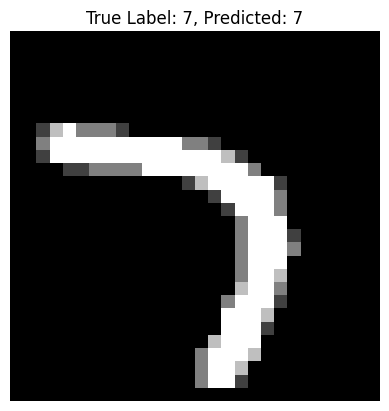

In [5]:
# Visualize a specific sample
sample_index = 60  # Index of the sample in the batch
sample = inputs[sample_index]
true_label = labels[sample_index].item()

visualize_prediction(model, sample, true_label)

### 1rst Approach
#### - After calculating the derivatives of the Cross Entropy Loss function with regard to each pixel, update every pixels values to the direction of the desired class.

Step 1/10000, Logit for Target: 7.4616
Target label 7 reached at step 48.


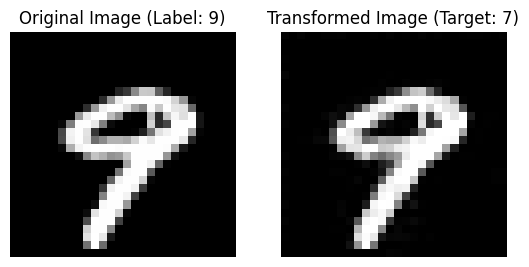

In [6]:
# Select an image and its true label
sample_index = 9
original_image = inputs[sample_index].unsqueeze(0)  # Add batch dimension
current_label = labels[sample_index].item()

# Define the target label
target_label = 7 # Transform the image to look like a "7"

# Perform the transformation
transformed_image = all_gradients(model, original_image, target_label, steps=10000, learning_rate=0.01, class_pred_perc=0.7) # if class_pred_perc = None,
                                                                                                                             # it stops when targeted_label == pred_label

plt.subplot(1, 2, 1)
plt.imshow(original_image.squeeze().numpy(), cmap="gray")
plt.title(f"Original Image (Label: {current_label})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_image.squeeze().detach().numpy(), cmap="gray")
plt.title(f"Transformed Image (Target: {target_label})")
plt.axis("off")

plt.show()

In [7]:
original_pred = classify_sample(model, original_image[0])
transformed_pred = classify_sample(model, transformed_image[0])
print(f'Prediction of the class of the original image: {original_pred}')
print(f'Prediction of the class of the transformed image: {transformed_pred}')

Prediction of the class of the original image: 9
Prediction of the class of the transformed image: 7


In [8]:
print('probabilities of the classifier for the original image')
softmax(model(original_image).detach().numpy()) ## 99.22% for class 9

probabilities of the classifier for the original image


array([[2.8403665e-08, 3.8329524e-11, 3.1362927e-07, 1.2807141e-04,
        7.1324299e-05, 4.7353535e-07, 7.5722234e-10, 7.5417766e-03,
        6.5168148e-05, 9.9219292e-01]], dtype=float32)

In [9]:
print('probabilities of the classifier for the transformed image')
softmax(model(transformed_image).detach().numpy()) ## 73.32% for class 7

probabilities of the classifier for the transformed image


array([[3.25122258e-08, 9.38643607e-11, 3.06300791e-07, 2.28316112e-05,
        2.44989715e-05, 6.12264586e-08, 1.08209615e-10, 7.33167648e-01,
        1.50697761e-05, 2.66769558e-01]], dtype=float32)

In [10]:
diff = (transformed_image[0] - original_image[0]).squeeze().detach().numpy() # 28 * 28 shaped tensor with the difference of the two images

In [11]:
np.sum(np.abs(diff)) # The absolute difference between the original image and the transformed image.

15.724489

In [12]:
# Filtering the smaller changes

# diff = np.where(np.abs(diff) < 0.5, 0, diff)

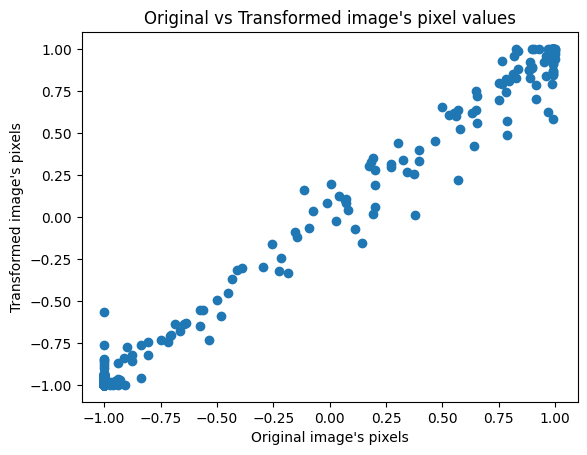

In [13]:
plt.scatter(original_image[0].detach().numpy(), transformed_image[0].detach().numpy())
plt.title("Original vs Transformed image's pixel values")
plt.xlabel("Original image's pixels")
plt.ylabel("Transformed image's pixels")
plt.show()

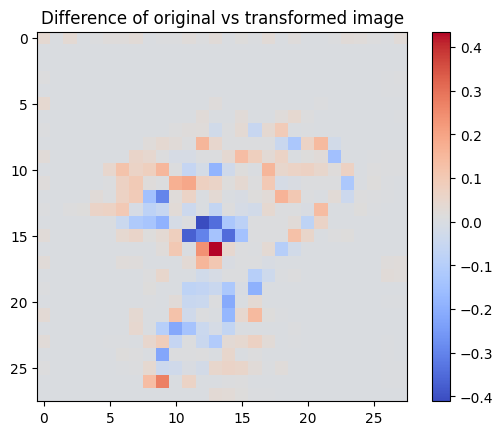

In [14]:
plt.imshow(diff, cmap='coolwarm') 
plt.title('Difference of original vs transformed image')
plt.colorbar()
plt.show()

# Pixels in red are the ones whose values increased (became more white)
# Pixels in blue are the ones whose values decreased (became more black)

### 2nd Approach
#### - After calculating the derivatives of the Cross Entropy Loss function with regard to each pixel, update the k highest impact pixel value (the k with the most significant gradient, usually k = 1) to the direction of the desired class

Step 1/1000, Logit for Target: 7.4616
Target label 7 reached at step 6.


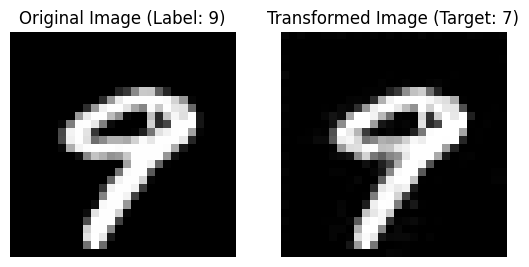

In [15]:
# Select an image and its true label
sample_index = 9
original_image = inputs[sample_index].unsqueeze(0)  # Add batch dimension
current_label = labels[sample_index].item()

# Define the target label
target_label = 7 # Transform the image to look like a "7"

# Perform the transformation
transformed_image = one_gradient(model, original_image, target_label, steps=1000, learning_rate=0.1, max_grad_pixels=1, class_pred_perc=0.7)

plt.subplot(1, 2, 1)
plt.imshow(original_image.squeeze().numpy(), cmap="gray")
plt.title(f"Original Image (Label: {current_label})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_image.squeeze().detach().numpy(), cmap="gray")
plt.title(f"Transformed Image (Target: {target_label})")
plt.axis("off")

plt.show()

In [16]:
original_pred = classify_sample(model, original_image[0])
transformed_pred = classify_sample(model, transformed_image[0])
print(f'Prediction of the class of the original image: {original_pred}')
print(f'Prediction of the class of the transformed image: {transformed_pred}')

Prediction of the class of the original image: 9
Prediction of the class of the transformed image: 7


In [17]:
print('probabilities of the classifier for the original image')
softmax(model(original_image).detach().numpy()) # 99.22% for class 9

probabilities of the classifier for the original image


array([[2.8403665e-08, 3.8329524e-11, 3.1362927e-07, 1.2807141e-04,
        7.1324299e-05, 4.7353535e-07, 7.5722234e-10, 7.5417766e-03,
        6.5168148e-05, 9.9219292e-01]], dtype=float32)

In [18]:
print('probabilities of the classifier for the transformed image')
softmax(model(transformed_image).detach().numpy()) # 89.52% for class 7

probabilities of the classifier for the transformed image


array([[2.0171971e-08, 6.1361242e-11, 1.5959282e-07, 7.7762497e-06,
        1.0540548e-05, 2.1767878e-08, 4.3572677e-11, 8.9524549e-01,
        6.6360467e-06, 1.0472935e-01]], dtype=float32)

In [19]:
diff = (transformed_image[0] - original_image[0]).squeeze().detach().numpy() # 28 * 28 shaped tensor with the difference of the two images
np.sum(np.abs(diff))

19.431568

In [20]:
#diff = np.where(np.abs(diff) < 0.5, 0, diff)

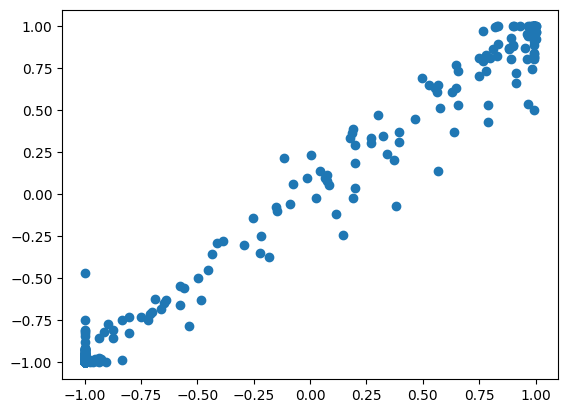

In [21]:
plt.scatter(original_image[0].detach().numpy(), transformed_image[0].detach().numpy())

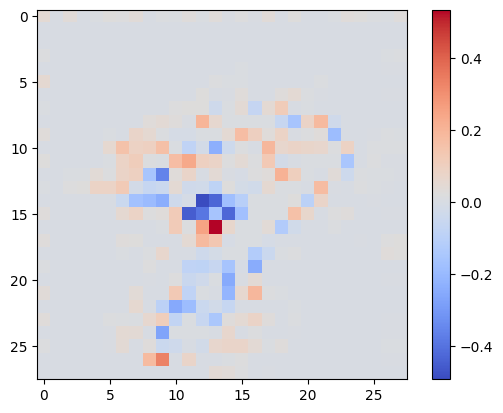

In [22]:
plt.imshow(diff, cmap='coolwarm')
plt.colorbar()
plt.show()

# Pixels in red are the ones whose values increased (became more white)
# Pixels in blue are the ones whose values decreased (became more black)